In [2]:
import tensorflow as tf
import os
import cv2
import shutil
import random
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, ReLU, MaxPooling2D, GlobalAveragePooling2D, Dense, Add, ZeroPadding2D, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.optimizers import Adam

In [3]:
base_path = '../../datasets/'
data_dir = os.path.join(base_path, 'to_train')

dataset_path = os.path.join(base_path, 'dataset')
train_path = os.path.join(data_dir, 'training')
valid_path = os.path.join(data_dir, 'validation')
testing_path = os.path.join(data_dir, 'testing')

In [3]:
class_names = []
split_ratio = 0.9

# Loop melalui setiap folder (menggunakan NPM sebagai nama folder)
for npm_folder in os.listdir(dataset_path):
  folder_path = os.path.join(dataset_path, npm_folder)

  # Cek apakah folder tersebut adalah direktori
  if os.path.isdir(folder_path):
    # List semua file dalam folder tersebut
    files = os.listdir(folder_path)

    # Jika ada lebih dari 2 file, kita akan melakukan split
    if len(files) >= 2:
      class_names.append(npm_folder)
      # Buat folder training dan validation jika belum ada
      os.makedirs(os.path.join(train_path, npm_folder), exist_ok=True)
      os.makedirs(os.path.join(testing_path), exist_ok=True)

      # Hitung jumlah file yang akan dipindahkan ke training
      num_files_to_move = int(len(files) * split_ratio)

      # Acak urutan file
      random.shuffle(files)

      # Pindahkan file ke folder training dan validation
      for i, file in enumerate(files):
        if i < num_files_to_move:
          # Pindahkan ke folder training
          shutil.copy(os.path.join(folder_path, file), os.path.join(train_path, npm_folder, file))
        else:
          # Pindahkan ke folder validation
          shutil.copy(os.path.join(folder_path, file), os.path.join(testing_path, file))
    else:
        print(f"Folder {npm_folder} kurang dari 2 file. Skipping...")

print("Data splitting completed.")

Data splitting completed.


In [4]:
num_classes = len(class_names)

In [4]:
img_height, img_width = 224, 224
batch_size = 8
train_gen = tf.keras.utils.image_dataset_from_directory(
    train_path,
    validation_split=0.2,
    subset='training',
    seed=123,
    label_mode='categorical',
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 211 files belonging to 11 classes.
Using 169 files for training.


In [5]:
validate_gen = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset='validation',
    seed=123,
    label_mode='categorical',
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 211 files belonging to 11 classes.
Using 42 files for validation.


In [30]:
def residual_block(x, filters, stride=1, use_projection=False):
    identity = x

    # First convolution layer in the block
    x = Conv2D(filters, kernel_size=(1, 1), strides=stride, padding='valid')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Second convolution layer in the block
    x = Conv2D(filters, kernel_size=(3, 3), strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Third convolution layer in the block
    x = Conv2D(filters * 4, kernel_size=(1, 1), strides=1, padding='valid')(x)
    x = BatchNormalization()(x)

    # Projection shortcut for identity
    if use_projection:
        identity = Conv2D(filters * 4, kernel_size=(1, 1), strides=stride, padding='valid')(identity)
        identity = BatchNormalization()(identity)

    # Adding the identity (skip connection) to the output
    x = Add()([x, identity])
    x = ReLU()(x)

    return x

In [26]:
def build_resnet101(input_shape=(224, 224, 3), num_classes=len(train_gen.class_names)):
    input_tensor = Input(shape=input_shape)

    x = ZeroPadding2D((3, 3))(input_tensor)
    
    # Stage 1
    x = Conv2D(64, (7, 7), strides=(2, 2), padding='valid')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = MaxPooling2D(pool_size=(3, 3), strides=(2,2), padding='same')(x)

    x = residual_block(x, filters=64, stride=1, use_projection=True)
    x = residual_block(x, filters=64)
    x = residual_block(x, filters=64)

# Stage 2
    x = residual_block(x, filters=128, stride=2, use_projection=True)
    for _ in range(3):
        x = residual_block(x, filters=128)

# Stage 3
    x = residual_block(x, filters=256, stride=2, use_projection=True)
    for _ in range(22):
        x = residual_block(x, filters=256)

# Stage 4
    x = residual_block(x, filters=512, stride=2, use_projection=True)
    for _ in range(2):
        x = residual_block(x, filters=512)

    # Global Average Pooling
    x = tf.keras.layers.AveragePooling2D(pool_size=(2, 2), padding='same')(x)

    # Fully connected layer
    x = tf.keras.layers.Dropout(.4)(x)
    x = tf.keras.layers.Flatten()(x)
    x = Dense(num_classes, activation='softmax')(x)

    # Creating the model
    model = Model(inputs=input_tensor, outputs=x, name='resnet101')

    return model

In [28]:
def build_resnet50(input_shape=(224, 224, 3), num_classes=len(train_gen.class_names)):
    input_tensor = Input(shape=input_shape)

    x = ZeroPadding2D((3, 3))(input_tensor)

    # Stage 1
    x = Conv2D(64, (7, 7), strides=(2, 2), padding='valid')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

    x = residual_block(x, filters=64, stride=1, use_projection=True)
    x = residual_block(x, filters=64)
    x = residual_block(x, filters=64)

# Stage 2
    x = residual_block(x, filters=128, stride=2, use_projection=True)
    for _ in range(3):
        x = residual_block(x, filters=128)

# Stage 3
    x = residual_block(x, filters=256, stride=2, use_projection=True)
    for _ in range(5):
        x = residual_block(x, filters=256)

# Stage 4
    x = residual_block(x, filters=512, stride=2, use_projection=True)
    for _ in range(2):
        x = residual_block(x, filters=512)

    # Global Average Pooling
    x = tf.keras.layers.AveragePooling2D(pool_size=(2, 2), padding='same')(x)

    # Fully connected layer
    x = tf.keras.layers.Dropout(.4)(x)
    x = tf.keras.layers.Flatten()(x)
    x = Dense(num_classes, activation='softmax')(x)

    # Creating the model
    model = Model(inputs=input_tensor, outputs=x, name='resnet50')

    return model

In [12]:
# Build ResNet-101 model
resnet101 = build_resnet101()

# Display model summary
resnet101.summary()
# tf.keras.utils.plot_model(resnet101)

Model: "resnet101"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d_1 (ZeroPadd  (None, 230, 230, 3)          0         ['input_2[0][0]']             
 ing2D)                                                                                           
                                                                                                  
 conv2d_1 (Conv2D)           (None, 112, 112, 64)         9472      ['zero_padding2d_1[0][0]']    
                                                                                                  
 batch_normalization_1 (Bat  (None, 112, 112, 64)         256       ['conv2d_1[0][0]']    

In [31]:
resnet50 = build_resnet50()

resnet50.summary()
# tf.keras.utils.plot_model(resnet50)

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d_1 (ZeroPadd  (None, 230, 230, 3)          0         ['input_2[0][0]']             
 ing2D)                                                                                           
                                                                                                  
 conv2d_1 (Conv2D)           (None, 112, 112, 64)         9472      ['zero_padding2d_1[0][0]']    
                                                                                                  
 batch_normalization_1 (Bat  (None, 112, 112, 64)         256       ['conv2d_1[0][0]']     

In [13]:
resnet101.compile(optimizer=Adam(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy'])

In [42]:
resnet50.compile(optimizer=Adam(learning_rate=0.01),
                 loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
saveBestModel = tf.keras.callbacks.ModelCheckpoint('../../datasets/resnet101_best_model',
                                                   monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
saveBestModel50 = tf.keras.callbacks.ModelCheckpoint('../../datasets/resnet50_best_model',
                                                     monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
epochs = 2

In [70]:
history_resnet50 = resnet50.fit(
    train_gen,
    epochs=epochs,
    validation_data=validate_gen,
    callbacks=[saveBestModel50]
)

Epoch 1/20


20/20 [==============================] - ETA: 0s - loss: 0.6513 - accuracy: 0.8497
Epoch 1: val_accuracy improved from -inf to 0.71429, saving model to ../../datasets\resnet50_best_model.h5
20/20 [==============================] - 34s 2s/step - loss: 0.6513 - accuracy: 0.8497 - val_loss: 5.8556 - val_accuracy: 0.7143
Epoch 2/20
20/20 [==============================] - ETA: 0s - loss: 0.7085 - accuracy: 0.8627
Epoch 2: val_accuracy improved from 0.71429 to 0.83333, saving model to ../../datasets\resnet50_best_model.h5
20/20 [==============================] - 35s 2s/step - loss: 0.7085 - accuracy: 0.8627 - val_loss: 2.0752 - val_accuracy: 0.8333
Epoch 3/20
20/20 [==============================] - ETA: 0s - loss: 0.7117 - accuracy: 0.8693
Epoch 3: val_accuracy did not improve from 0.83333
20/20 [==============================] - 34s 2s/step - loss: 0.7117 - accuracy: 0.8693 - val_loss: 1.5693 - val_accuracy: 0.7857
Epoch 4/20
20/20 [==============================] - ETA: 0s - loss: 0.7789

In [15]:
history = resnet101.fit(train_gen,
          epochs=epochs,
          validation_data=validate_gen,
          callbacks=[saveBestModel]
          )

Epoch 1/2
22/22 [==============================] - ETA: 0s - loss: 59.4240 - accuracy: 0.0828
Epoch 1: val_accuracy improved from -inf to 0.02381, saving model to ../../datasets\resnet101_best_model
INFO:tensorflow:Assets written to: ../../datasets\resnet101_best_model\assets


INFO:tensorflow:Assets written to: ../../datasets\resnet101_best_model\assets


22/22 [==============================] - 211s 7s/step - loss: 59.4240 - accuracy: 0.0828 - val_loss: 111802049057419605917838008463130624.0000 - val_accuracy: 0.0238
Epoch 2/2
22/22 [==============================] - ETA: 0s - loss: 33.0712 - accuracy: 0.1124
Epoch 2: val_accuracy improved from 0.02381 to 0.09524, saving model to ../../datasets\resnet101_best_model
INFO:tensorflow:Assets written to: ../../datasets\resnet101_best_model\assets


INFO:tensorflow:Assets written to: ../../datasets\resnet101_best_model\assets


22/22 [==============================] - 149s 7s/step - loss: 33.0712 - accuracy: 0.1124 - val_loss: 11807348135682834738184192.0000 - val_accuracy: 0.0952


In [53]:
best_model.summary()

Model: "resnet101"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d_1 (ZeroPadd  (None, 230, 230, 3)          0         ['input_2[0][0]']             
 ing2D)                                                                                           
                                                                                                  
 conv2d_104 (Conv2D)         (None, 112, 112, 64)         9472      ['zero_padding2d_1[0][0]']    
                                                                                                  
 batch_normalization_104 (B  (None, 112, 112, 64)         256       ['conv2d_104[0][0]']  

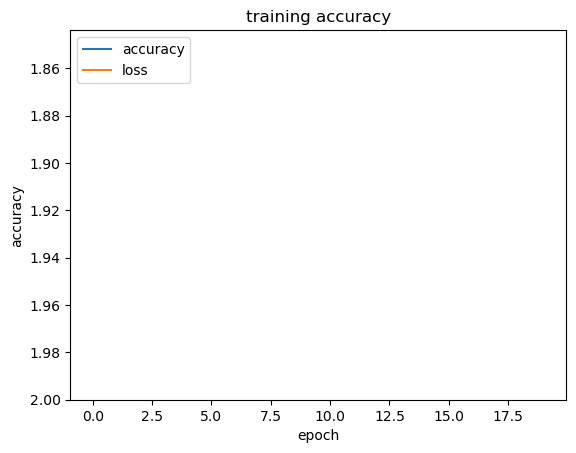

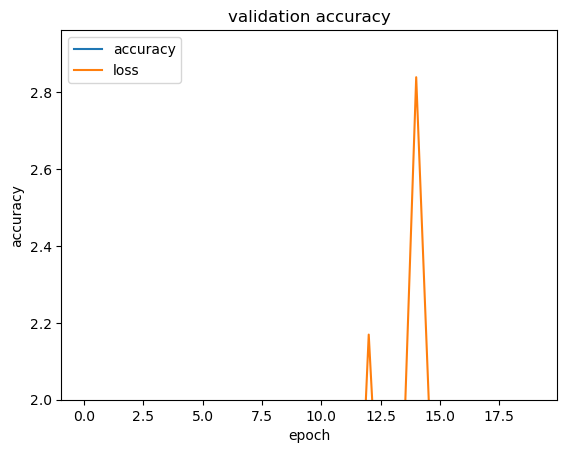

In [72]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.title('training accuracy')
plt.ylim(2)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'loss'], loc='upper left')
plt.show()

plt.plot(history.history['val_accuracy'])
plt.plot(history.history['val_loss'])
plt.title('validation accuracy')
plt.ylim(2)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'loss'], loc='upper left')
plt.show()

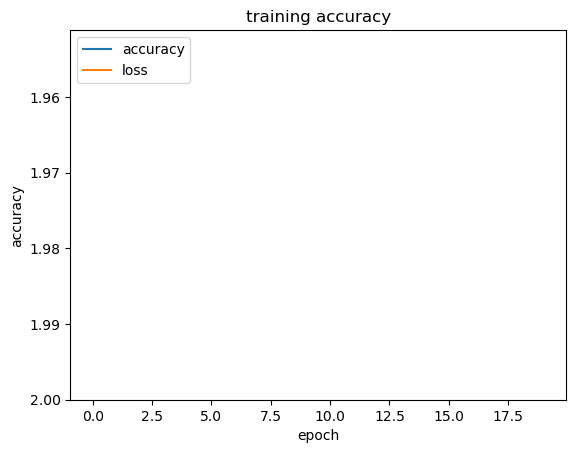

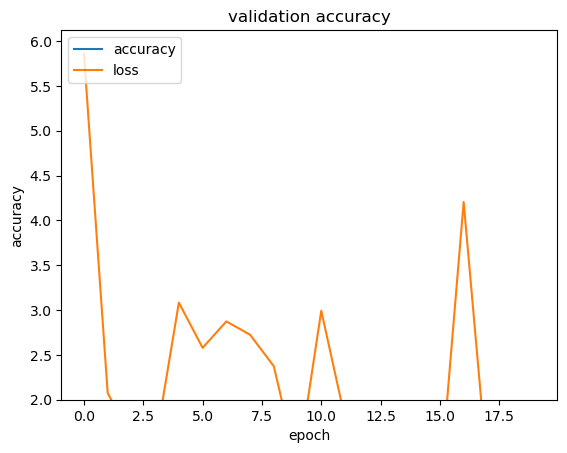

In [73]:
plt.plot(history_resnet50.history['accuracy'])
plt.plot(history_resnet50.history['loss'])
plt.title('training accuracy')
plt.ylim(2)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'loss'], loc='upper left')
plt.show()

plt.plot(history_resnet50.history['val_accuracy'])
plt.plot(history_resnet50.history['val_loss'])
plt.title('validation accuracy')
plt.ylim(2)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'loss'], loc='upper left')
plt.show()

In [6]:
model_resnet101 = keras.models.load_model('../../models/resnet101_best.h5')
model_resnet50 = keras.models.load_model('../../models/resnet50_best.h5')


In [23]:
model_resnet50.evaluate(validate_gen, verbose=2)

6/6 - 3s - loss: 2.0144 - accuracy: 0.8810 - 3s/epoch - 512ms/step


[2.01442551612854, 0.8809523582458496]

In [24]:
model_resnet101.evaluate(validate_gen, verbose=2)

6/6 - 9s - loss: 2.3965 - accuracy: 0.8333 - 9s/epoch - 2s/step


[2.3964977264404297, 0.8333333134651184]

In [20]:
import visualkeras

visualkeras.layered_view(model_resnet50).show()


In [21]:
visualkeras.layered_view(model_resnet101).show()

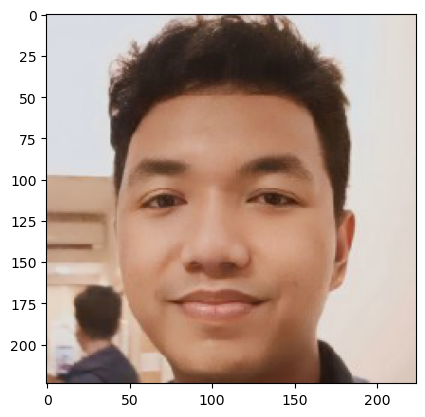

1/1 [==============================] - 1s 934ms/step
Nama File:  1690205326527.jpg
Prediksi 101:  2117051027
Prediksi 50:  2117051019
Probabilitas 101:  0.48866015672683716
Probabilitas 50:  0.9999102354049683




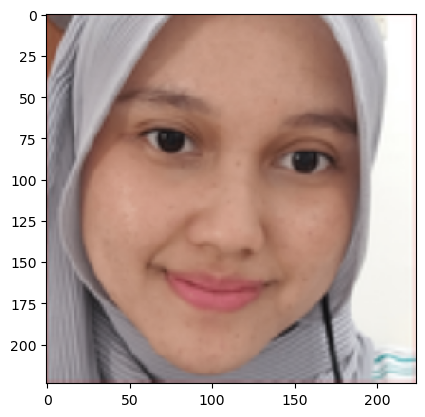

1/1 [==============================] - 0s 85ms/step
Nama File:  20230413_094837.png
Prediksi 101:  2117051050
Prediksi 50:  2117051050
Probabilitas 101:  0.36874696612358093
Probabilitas 50:  0.6466217041015625




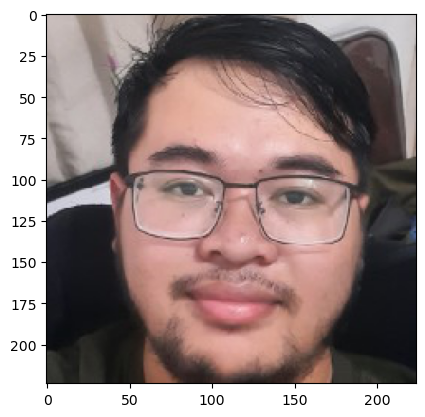

1/1 [==============================] - 0s 74ms/step
Nama File:  20230513_205923.jpg
Prediksi 101:  2117051009
Prediksi 50:  2117051009
Probabilitas 101:  0.926354706287384
Probabilitas 50:  1.0




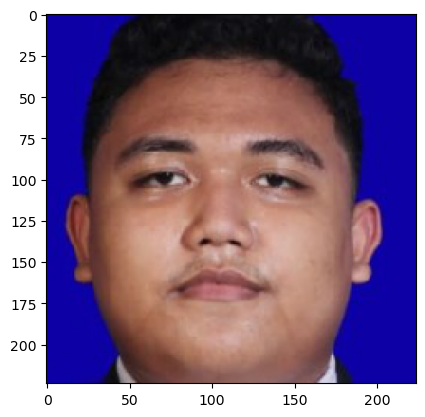

1/1 [==============================] - 0s 75ms/step
Nama File:  2157051006_Muhammad Fadhilah Ramadhani_12.jpg
Prediksi 101:  2117051027
Prediksi 50:  2117051043
Probabilitas 101:  1.0
Probabilitas 50:  0.9996194839477539




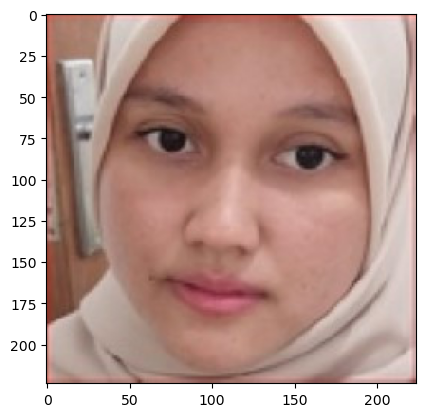

1/1 [==============================] - 0s 81ms/step
Nama File:  IMG-20230516-WA0025.jpg
Prediksi 101:  2017051017
Prediksi 50:  2117051050
Probabilitas 101:  0.8875015377998352
Probabilitas 50:  0.7015466690063477




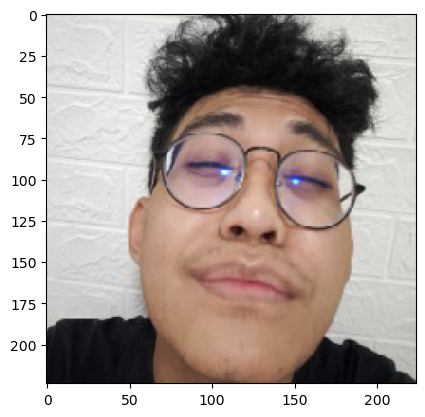

1/1 [==============================] - 0s 80ms/step
Nama File:  IMG20231001213547.jpg
Prediksi 101:  2117051019
Prediksi 50:  2117051019
Probabilitas 101:  1.0
Probabilitas 50:  0.9999990463256836




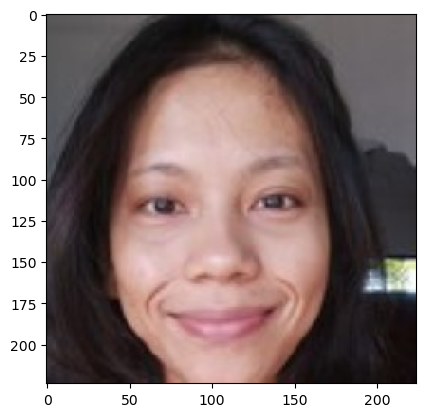

1/1 [==============================] - 0s 92ms/step
Nama File:  IMG_20230930_121321_957.jpg
Prediksi 101:  2117051009
Prediksi 50:  2117051009
Probabilitas 101:  1.0
Probabilitas 50:  1.0




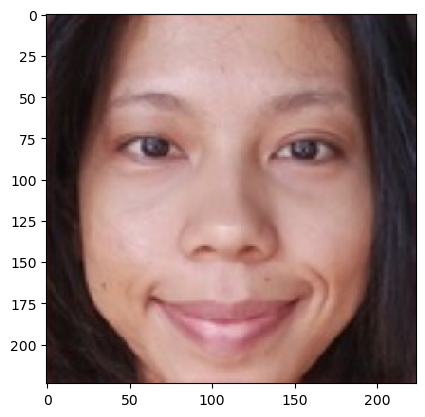

1/1 [==============================] - 0s 79ms/step
Nama File:  IMG_20230930_121418_053.jpg
Prediksi 101:  2117051009
Prediksi 50:  2117051009
Probabilitas 101:  0.977925181388855
Probabilitas 50:  1.0




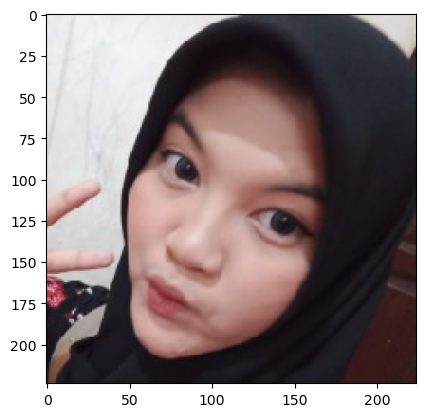

1/1 [==============================] - 0s 75ms/step
Nama File:  IMG_20231002_103421.jpg
Prediksi 101:  2117051009
Prediksi 50:  2117051043
Probabilitas 101:  0.9999996423721313
Probabilitas 50:  0.9999996423721313




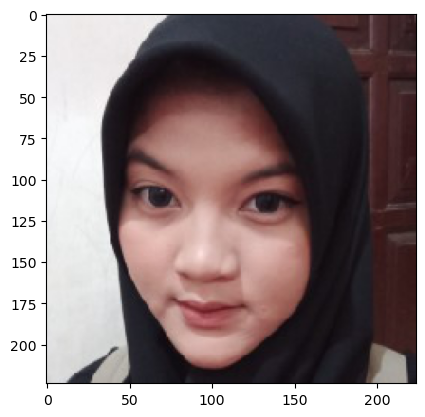

1/1 [==============================] - 0s 96ms/step
Nama File:  IMG_20231003_131845.jpg
Prediksi 101:  2157051001
Prediksi 50:  2117051043
Probabilitas 101:  0.6636718511581421
Probabilitas 50:  1.0




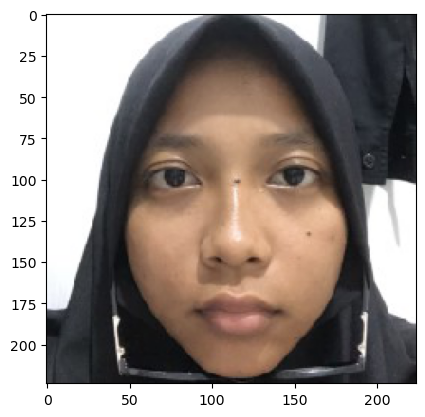

1/1 [==============================] - 0s 79ms/step
Nama File:  IMG_9237.jpg
Prediksi 101:  2117051095
Prediksi 50:  2117051095
Probabilitas 101:  0.995854914188385
Probabilitas 50:  1.0




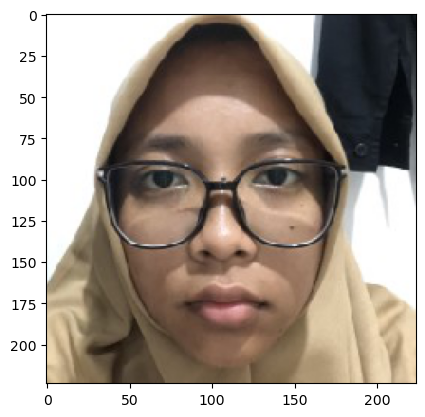

1/1 [==============================] - 0s 85ms/step
Nama File:  IMG_9248.jpg
Prediksi 101:  2117051095
Prediksi 50:  2157051006
Probabilitas 101:  0.5836710333824158
Probabilitas 50:  0.9999886751174927




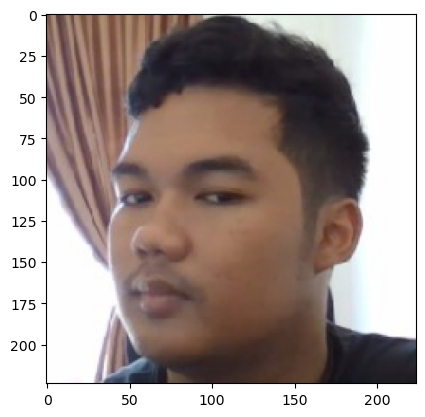

1/1 [==============================] - 0s 77ms/step
Nama File:  WIN_20230930_10_53_37_Pro.jpg
Prediksi 101:  2157051001
Prediksi 50:  2117051019
Probabilitas 101:  0.9344256520271301
Probabilitas 50:  0.9999898672103882




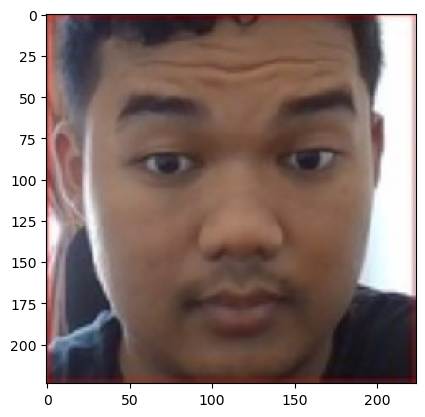

1/1 [==============================] - 0s 80ms/step
Nama File:  WIN_20230930_10_53_38_Pro.jpg
Prediksi 101:  2017051001
Prediksi 50:  2117051019
Probabilitas 101:  0.995881199836731
Probabilitas 50:  1.0




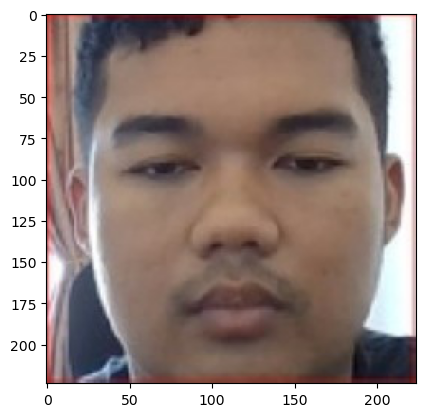

1/1 [==============================] - 0s 77ms/step
Nama File:  WIN_20230930_10_53_41_Pro.jpg
Prediksi 101:  2017051001
Prediksi 50:  2117051019
Probabilitas 101:  0.8643147945404053
Probabilitas 50:  0.9595334529876709




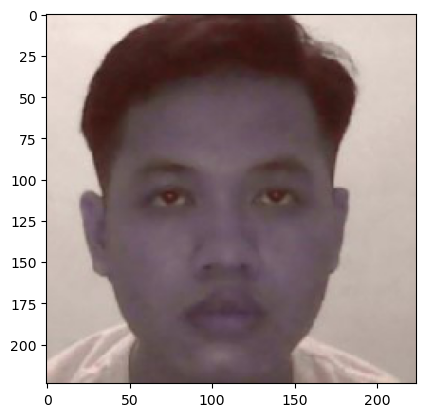

1/1 [==============================] - 0s 79ms/step
Nama File:  WIN_20231002_21_48_30_Pro.jpg
Prediksi 101:  2157051001
Prediksi 50:  2117051019
Probabilitas 101:  0.9978602528572083
Probabilitas 50:  0.5221826434135437




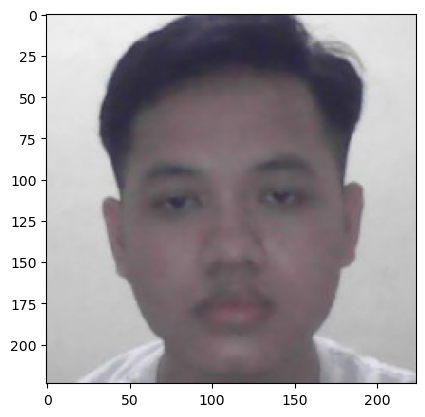

1/1 [==============================] - 0s 83ms/step
Nama File:  WIN_20231002_21_49_13_Pro (2).jpg
Prediksi 101:  2157051001
Prediksi 50:  2117051019
Probabilitas 101:  0.9771947264671326
Probabilitas 50:  0.9734929203987122




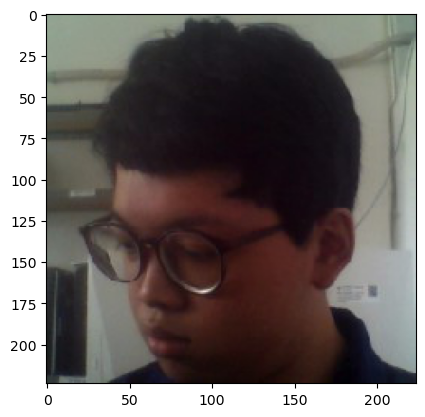

1/1 [==============================] - 0s 76ms/step
Nama File:  WIN_20231003_13_35_29_Pro.jpg
Prediksi 101:  2117051048
Prediksi 50:  2117051048
Probabilitas 101:  0.9974926710128784
Probabilitas 50:  1.0




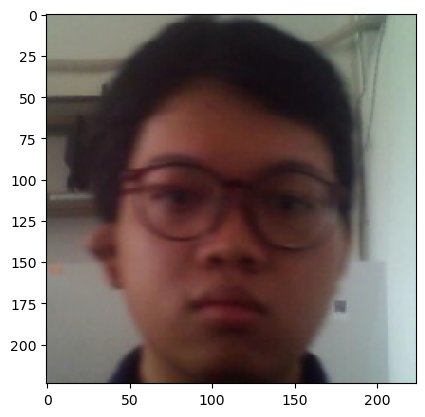

1/1 [==============================] - 0s 77ms/step
Nama File:  WIN_20231003_13_41_02_Pro.jpg
Prediksi 101:  2117051048
Prediksi 50:  2117051048
Probabilitas 101:  0.9993384480476379
Probabilitas 50:  1.0




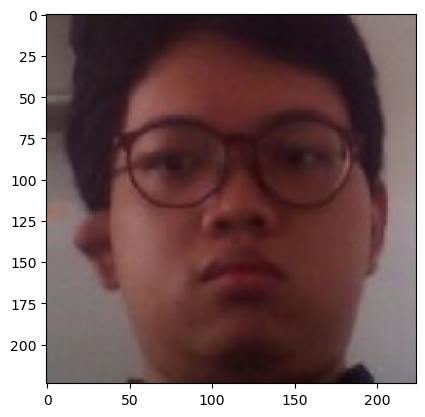

1/1 [==============================] - 0s 85ms/step
Nama File:  WIN_20231003_13_41_33_Pro.jpg
Prediksi 101:  2117051048
Prediksi 50:  2157051006
Probabilitas 101:  0.9650471806526184
Probabilitas 50:  0.9818652272224426




In [6]:
labels = train_gen.class_names
for image in os.listdir(testing_path):
  
  image_path = os.path.join(testing_path, image)

  img = load_img(image_path, target_size=(224,224))


  # tf.keras.applications.resnetS.preprocess_input(img)


  plt.imshow(img)
  plt.show()

  X = img_to_array(img)
  
  X = np.expand_dims(X, axis=0)

  images = np.vstack([X])

  predict_resnet101 = model_resnet101.predict(images)
  predict_resnet50 = model_resnet50.predict(images)

  predicted_class_resnet101 = np.argmax(predict_resnet101, axis=1)[0]
  predicted_class_resnet50 = np.argmax(predict_resnet50, axis=1)[0]

  predictions_resnet101 = labels[predicted_class_resnet101]
  predictions_resnet50 =  labels[predicted_class_resnet50]

  print('Nama File: ', image)
  print('Prediksi 101: ', predictions_resnet101)
  print('Prediksi 50: ', predictions_resnet50)
  print('Probabilitas 101: ', max(predict_resnet101.tolist()[0]))
  print('Probabilitas 50: ', max(predict_resnet50.tolist()[0]))
  
  print('\n')